Keypoints detected


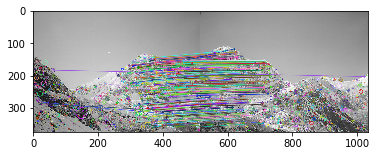

Homography matrix, H 
 [[ 1.58799966e+00 -2.91541838e-01 -3.95539425e+02]
 [ 4.48199617e-01  1.43139761e+00 -1.90370131e+02]
 [ 1.20864262e-03 -5.94920214e-05  1.00000000e+00]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1daa5096048>, None)

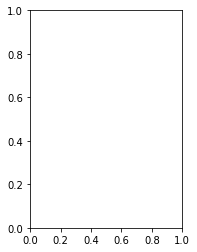

In [13]:
import cv2
import numpy as np
import random
from matplotlib import cm
from matplotlib import pyplot as plt

UBIT = 'sdwivedi';
np.random.seed(sum([ord(c) for
c in UBIT]))


def outputImage(img, outImageName):
    cv2.imwrite('C:/Users/Shraddha/Desktop/CVIP/HW_Proj_2/OutputImages/'+outImageName+'.jpg', img)
    return 1
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def warpImg1to2Images(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1Copy.shape[:2]
    h2,w2 = img1Copy.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, M)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

img1 = cv2.imread('./proj2_data/data/mountain1.jpg')
img2 = cv2.imread('./proj2_data/data/mountain2.jpg')
img1Copy=img1.copy()
img2Copy=img2.copy()
img1gray= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2gray= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
#detecting the keypoints of image
keypoints1 = sift.detect(img1gray,None)
keypoints2 = sift.detect(img2gray,None)

#drawing a circle according to size of keypoints with its orientation
image1=cv2.drawKeypoints(img1gray,keypoints1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2=cv2.drawKeypoints(img2gray,keypoints2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#computing descriptors
keypoints1,des1 = sift.compute(img1gray,keypoints1) 
keypoints2,des2 = sift.compute(img2gray,keypoints2)

print("Keypoints detected")
outputImage(image1,"task1_sift1")
outputImage(image2,"task1_sift2")

bf = cv2.BFMatcher()
#returns k best matches. here k=2 
matches = bf.knnMatch(des1,des2, k=2)

goodMatches = []
goodMatches_without_list = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        goodMatches.append([m])
        goodMatches_without_list.append(m)
       
    image3 = cv2.drawMatches(image1,keypoints1,image2,keypoints2,goodMatches_without_list,None,flags=2)     
outputImage(image3,"task1_matches_knn")
# goodMatches_without_list = random.sample(goodMatches_without_list, 10)
plt.imshow(image3)
plt.show()

 # Extract location of good matches
points1 = np.zeros((len(goodMatches), 2), dtype=np.float32)
points2 = np.zeros((len(goodMatches), 2), dtype=np.float32)

matchCount=5

if len(goodMatches_without_list)>matchCount:
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in goodMatches_without_list ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in goodMatches_without_list ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    matchesMask =  random.sample(matchesMask, 10)
    height, width, channels = image1.shape
    pts = np.float32([ [0,0],[0,height-1],[width-1,height-1],[width-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)


    print("Homography matrix, H \n", M)


else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
goodMatches_without_list = random.sample(goodMatches_without_list, 10)
image4 = cv2.drawMatches(image1,keypoints1,image2,keypoints2,goodMatches_without_list,None,**draw_params)
outputImage(image4,"task1_matches")


result = warpImg1to2Images(img1Copy, img1Copy, M)
plt.subplot(122),plt.imsave('task1_pano', result, cmap = cm.gray)

 
